In [164]:
import json
import xml.etree.ElementTree as ET
import networkx as nx

In [172]:
# Load the drug-target 
# File path where the JSON file is saved
file_path = '../outputs/nct-drug-cancer-pathways-06062024.json'

# Read the JSON file back into a dictionary
with open(file_path, 'r') as json_file:
    drug_target_info_dict = json.load(json_file)

print("Dictionary has been loaded from", file_path)


Dictionary has been loaded from ../outputs/nct-drug-cancer-pathways-06062024.json


In [173]:
len(drug_target_info_dict)

18293

In [176]:
# counter = 0

# for key, value in drug_target_info_dict.items():
#     print("Key:", key)
#     print("\tValue: ", value)

        
#     counter+=1
#     if counter > 10:
#         break

In [177]:
## loading the kegg cancer pathways
tree = ET.parse('../resources/kegg-hsa05224-cancer-pathways.xml')

# Parse the XML data
# root = ET.fromstring(tree)

root = tree.getroot()

cancer_pathways = {}
# Now you can use the root element to find entries of type "gene"
for entry in root.findall("entry"):
    if entry.get("type") == "gene":
        node_name = entry.get('name')
        # cancer_pathways
        graphics = entry.find("graphics")
        pathway = graphics.get("name")
        # print(path)
        splits = pathway.lower().strip('...').split(',')
        cancer_pathways[node_name] = splits
    # print('------------')



In [178]:
# candcounter = 0
prox_config = [10, 20, 30, 40, 50]
PROXIMITY = 50
pathways_evidence = {}
for pwnode, pathway in cancer_pathways.items():
    docs_evidence = []
    already_found = set()
    # print("pathway: ", pathway)
    stripped_list = [element.strip() for element in pathway]
    for pmid, candidates in drug_target_info_dict.items():
        # print("Doc candidates: ", candidates)
        
        # only capture those of proximity <= 10
        for cand in candidates:
    
            drug_target_cand = cand[0].strip()+"|"+cand[1].strip()
            if cand[1].strip() in stripped_list and int(cand[2]) <= PROXIMITY and drug_target_cand not in already_found:
                # print("Found: ", drug_target_cand)
                
                already_found.add(drug_target_cand)
                docs_evidence.append((pmid, cand[0].strip(), cand[1].strip(), int(cand[2])))                    
                    
    if len(docs_evidence) > 0:
        splits = pwnode.split()
        if len(splits) > 1:        
            pathways_evidence[splits[0]] = docs_evidence   
        else:
            pathways_evidence[pwnode] = docs_evidence 

In [197]:
path_to_pickle_graph_to_read = '../outputs/gpt-pe-combos-graph.pickle' 
chatGPT_combos_graph = nx.read_gpickle(path_to_pickle_graph_to_read)

In [198]:
nodes = chatGPT_combos_graph.nodes()
    
edges = chatGPT_combos_graph.edges()


In [201]:
print(len(nodes))
print(len(edges))

# count = 0
# for node in nodes:
#     print(node)
#     count += 1
#     if count > 10:
#         break


3281
4502


In [182]:
print(len(pathways_evidence.items()))

46


In [223]:
counter_in = 0
counter_out = 0
count_break = 0
combos_support = {}
for key, list_evidence in pathways_evidence.items(): 
    list_evid = []

    for e in list_evidence:
        if e[1] in list(nodes):
            list_evid.append(e[1])
            
            counter_in +=1 
        else:
            counter_out += 1
    if len(list_evid) > 1:
        combos_support[key] = list_evid
        
    
    
            
print("counter_in", counter_in)            
print("counter_out", counter_out)   
print("pathways_evidence.items()", len(pathways_evidence.items()))



counter_in 980
counter_out 198
pathways_evidence.items() 46


In [222]:
print("Path ID: ", "Drug Count: ")
for path, drugs in combos_support.items():
    print(path, len(drugs))

Path ID:  Drug Count: 
hsa:2099 91
hsa:1956 68
hsa:8202 10
hsa:3265 3
hsa:5604 10
hsa:5594 43
hsa:2885 5
hsa:6654 3
hsa:182 11
hsa:4851 5
hsa:2475 29
hsa:6198 4
hsa:3479 25
hsa:3480 7
hsa:2064 108
hsa:2353 19
hsa:5241 66
hsa:5290 45
hsa:10000 4
hsa:5728 28
hsa:595 12
hsa:4609 37
hsa:1499 2
hsa:1019 10
hsa:5925 32
hsa:1869 8
hsa:3815 38
hsa:1026 42
hsa:2260 4
hsa:8600 9
hsa:1950 16
hsa:672 34
hsa:675 26
hsa:2246 3
hsa:2324 14
hsa:7157 64
hsa:581 26
hsa:578 13


In [406]:
# print("Pathway ID,","# Pubmed Documents,", "# Unique Drugs,", "# Unique Proteins") 
# print("------------------------------------------------------------------------------------------------")

# # dict_summary_by_prox10 = pathways_evidence

dict_summary_by_prox = {}

for key, val in pathways_evidence.items(): 
    # for item in val:
    #     print("item[0]", item[0], "item[1]", item[1])
    
    docs = [item[0] for item in val] 
    drugs = [item[1] for item in val]
    proteins = [item[2] for item in val]    
    # print(item[0])
    # print('--------------')
    
    dict_summary_by_prox[key] = ("Proximity:"+str(PROXIMITY), len(set(docs)), len(set(drugs)), len(set(proteins)))    

In [40]:
# len(dict_summary_by_prox)

In [39]:
# dict_summary_by_prox
# for key, val in dict_summary_by_prox.items(): 
#     print(key, val[0], val[1], val[2], val[3], sep=",")

In [132]:
import pandas as pd

# Load individual sheets
file_path = '../outputs/disco-by-prox-sheets.xlsx'

sheet1_df = pd.read_excel(file_path, sheet_name='Prox-10')
sheet2_df = pd.read_excel(file_path, sheet_name='Prox-20')
sheet3_df = pd.read_excel(file_path, sheet_name='Prox-30')
sheet4_df = pd.read_excel(file_path, sheet_name='Prox-40')
sheet5_df = pd.read_excel(file_path, sheet_name='Prox-50')

# Function to ensure 'Proximity Value' column is numeric and get descriptive statistics
def get_descriptive_stats(df, col_name, sheet_name):
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    descriptive_stats = df[col_name].describe()
    descriptive_stats.name = sheet_name
    return descriptive_stats


colum_name = 'Proteins'

# Get descriptive statistics for each sheet
descriptive_stats_10 = get_descriptive_stats(sheet1_df, colum_name, 'Prox-10')
descriptive_stats_20 = get_descriptive_stats(sheet2_df, colum_name, 'Prox-20')
descriptive_stats_30 = get_descriptive_stats(sheet3_df, colum_name, 'Prox-30')
descriptive_stats_40 = get_descriptive_stats(sheet4_df, colum_name, 'Prox-40')
descriptive_stats_50 = get_descriptive_stats(sheet5_df, colum_name, 'Prox-50')

# Combine all descriptive statistics into a single DataFrame
all_descriptive_stats = pd.concat([descriptive_stats_10, descriptive_stats_20, descriptive_stats_30, descriptive_stats_40, descriptive_stats_50], axis=1)

# Print the combined descriptive statistics
print(all_descriptive_stats)


         Prox-10    Prox-20    Prox-30    Prox-40    Prox-50
count  37.000000  41.000000  45.000000  45.000000  46.000000
mean    1.916667   2.121951   2.295455   2.422222   2.434783
std     1.320248   1.417659   1.470614   1.630517   1.628253
min     1.000000   1.000000   1.000000   1.000000   1.000000
25%     1.000000   1.000000   1.000000   1.000000   1.000000
50%     1.000000   2.000000   2.000000   2.000000   2.000000
75%     3.000000   3.000000   3.000000   3.000000   3.000000
max     7.000000   8.000000   8.000000   8.000000   8.000000


In [137]:
colum_name = 'PubMed'

# Get descriptive statistics for each sheet
descriptive_stats_10 = get_descriptive_stats(sheet1_df, colum_name, 'Prox-10')
descriptive_stats_20 = get_descriptive_stats(sheet2_df, colum_name, 'Prox-20')
descriptive_stats_30 = get_descriptive_stats(sheet3_df, colum_name, 'Prox-30')
descriptive_stats_40 = get_descriptive_stats(sheet4_df, colum_name, 'Prox-40')
descriptive_stats_50 = get_descriptive_stats(sheet5_df, colum_name, 'Prox-50')

# Combine all descriptive statistics into a single DataFrame
all_descriptive_stats = pd.concat([descriptive_stats_10, descriptive_stats_20, descriptive_stats_30, descriptive_stats_40, descriptive_stats_50], axis=1)

# Print the combined descriptive statistics
print(all_descriptive_stats)

         Prox-10    Prox-20    Prox-30    Prox-40     Prox-50
count  36.000000  41.000000  44.000000  45.000000   46.000000
mean    8.638889  13.902439  17.431818  20.488889   22.934783
std    10.060255  16.267767  20.129115  22.918454   25.618919
min     1.000000   1.000000   1.000000   1.000000    1.000000
25%     2.000000   2.000000   3.750000   4.000000    5.250000
50%     5.500000   7.000000   9.000000  10.000000   12.500000
75%    10.250000  18.000000  25.500000  26.000000   32.500000
max    48.000000  72.000000  86.000000  98.000000  113.000000


In [134]:
# Defining the two lists to perform element-wise division
numerators = [1.9, 2.1, 2.29, 2.4, 2.4]
denominators = [7, 11, 14, 17, 18]

# Performing the division
results = [n / d for n, d in zip(numerators, denominators)]
print(results, sep=",")


[0.2714285714285714, 0.19090909090909092, 0.16357142857142856, 0.1411764705882353, 0.13333333333333333]


In [135]:
# Defining the two lists to perform element-wise division
numerators = [7, 8, 8, 8, 8]
denominators = [25, 43,  59,  65,  69]

# Performing the division
results = [n / d for n, d in zip(numerators, denominators)]
print(results, sep=",")

[0.28, 0.18604651162790697, 0.13559322033898305, 0.12307692307692308, 0.11594202898550725]


In [136]:
# Defining the two lists to perform element-wise division
numerators = [1.9, 2.1, 2.29, 2.4, 2.4]
denominators = [7, 11, 14, 17, 18]

# Performing the division
results = [n / d for n, d in zip(numerators, denominators)]
results

[0.2714285714285714,
 0.19090909090909092,
 0.16357142857142856,
 0.1411764705882353,
 0.13333333333333333]

In [139]:
# [9, 14, 17, 20, 23] [48, 72, 86, 98, 113]

# Defining the two lists to perform element-wise division
numerators = [9, 14, 17, 20, 23]
denominators = [48, 72, 86, 98, 113]

# Performing the division
results = [n / d for n, d in zip(numerators, denominators)]
print(results, sep=",")



[0.1875, 0.19444444444444445, 0.19767441860465115, 0.20408163265306123, 0.20353982300884957]


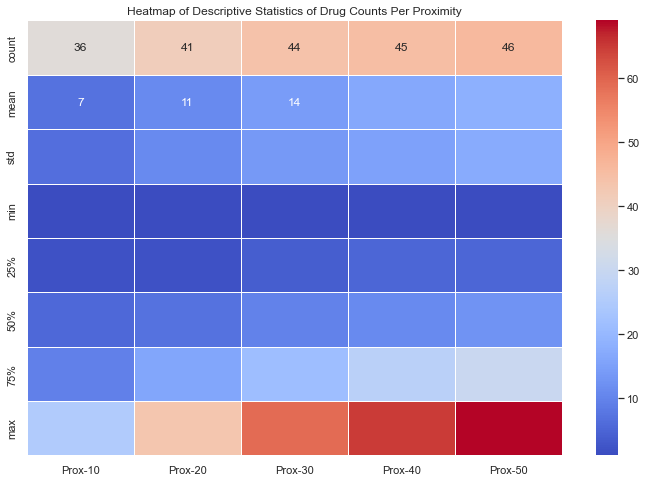

In [121]:
import seaborn as sns

# Set up the heatmap
plt.figure(figsize=(12, 8))


sns.heatmap(all_descriptive_stats, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Descriptive Statistics of Drug Counts Per Proximity')

# Save the heatmap to a file
output_file_path = '../outputs/descriptive_stats_4drugs_heatmap.png'
plt.savefig(output_file_path)

# Show the plot
plt.show()

In [144]:
# Defining the two lists of numbers (For Drugs)
vector1 = [7, 11, 14, 17, 18]
vector2 = [25, 43, 59, 65, 69]

# Performing the division element-wise
ratios = [v1 / v2 for v1, v2 in zip(vector1, vector2)]
print(ratios, sep=",")

[0.28, 0.2558139534883721, 0.23728813559322035, 0.26153846153846155, 0.2608695652173913]


In [145]:
# Defining the two lists of numbers (For Proteins as Targets)
vector1 = [1.9, 2.1,  2.29, 2.4, 2.4]
vector2 = [7, 8, 8, 8, 8]

# Performing the division element-wise
ratios = [v1 / v2 for v1, v2 in zip(vector1, vector2)]
print(ratios, sep=",")

[0.2714285714285714, 0.2625, 0.28625, 0.3, 0.3]


In [146]:
# (9, 14, 17, 20, 23) while the max (48, 72, 86, 98, 113)
# Defining the two lists of numbers (For PubMed Mean-Max Ratio)
vector1 = [9, 14, 17, 20, 23]
vector2 = [48, 72, 86, 98, 113]

# Performing the division element-wise
ratios = [v1 / v2 for v1, v2 in zip(vector1, vector2)]
print(ratios, sep=",")

[0.1875, 0.19444444444444445, 0.19767441860465115, 0.20408163265306123, 0.20353982300884957]


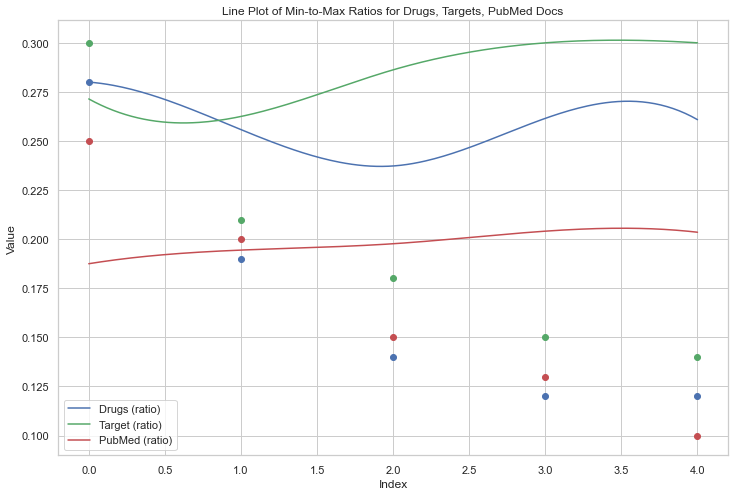

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Sample data for three sets of ratios
drugs = [0.28, 0.2558139534883721, 0.23728813559322035, 0.26153846153846155, 0.2608695652173913]
targets = [0.2714285714285714, 0.2625, 0.28625, 0.3, 0.3]
pubmed = [0.1875, 0.19444444444444445, 0.19767441860465115, 0.20408163265306123, 0.20353982300884957]


x = np.arange(len(ratios1))

# Interpolating to make the plots smooth
f1 = interp1d(x, drugs, kind='cubic')
f2 = interp1d(x, targets, kind='cubic')
f3 = interp1d(x, pubmed, kind='cubic')

x_smooth = np.linspace(x.min(), x.max(), 200)
ratios1_smooth = f1(x_smooth)
ratios2_smooth = f2(x_smooth)
ratios3_smooth = f3(x_smooth)

# Plotting the data
plt.figure(figsize=(12, 8))
plt.plot(x_smooth, ratios1_smooth, color='b', label='Drugs (ratio)')
plt.plot(x_smooth, ratios2_smooth, color='g', label='Target (ratio)')
plt.plot(x_smooth, ratios3_smooth, color='r', label='PubMed (ratio)')
plt.scatter(x, ratios1, color='b', zorder=5)  # Original points for reference
plt.scatter(x, ratios2, color='g', zorder=5)  # Original points for reference
plt.scatter(x, ratios3, color='r', zorder=5)  # Original points for reference
plt.title('Line Plot of Min-to-Max Ratios for Drugs, Targets, PubMed Docs')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)


# Save the heatmap to a file
output_file_path = '../outputs/min2max-ratios.png'
plt.savefig(output_file_path)


plt.show()

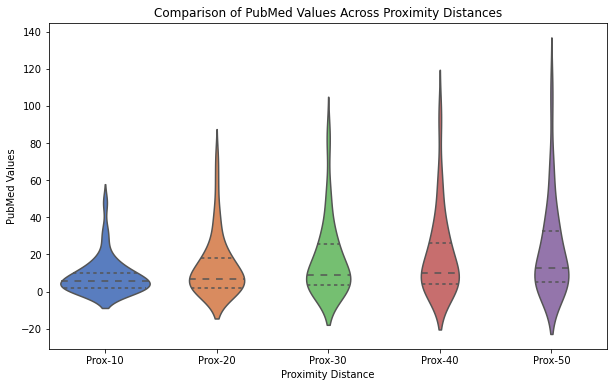

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded the dataframes
# sheet1_df, sheet2_df, sheet3_df, sheet4_df, sheet5_df

# Extracting PubMed column from each dataframe
pubmed_10 = sheet1_df['PubMed']
pubmed_20 = sheet2_df['PubMed']
pubmed_30 = sheet3_df['PubMed']
pubmed_40 = sheet4_df['PubMed']
pubmed_50 = sheet5_df['PubMed']

# Combining all PubMed values into one dataset
all_pubmed = pd.concat([pubmed_10, pubmed_20, pubmed_30, pubmed_40, pubmed_50], axis=1)
all_pubmed.columns = ['Prox-10', 'Prox-20', 'Prox-30', 'Prox-40', 'Prox-50']

# Reshaping the data for violin plot
all_pubmed_melted = all_pubmed.melt(var_name='Proximity Distance', value_name='PubMed')

# Creating a colorful violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Proximity Distance', y='PubMed', data=all_pubmed_melted, palette='muted', inner='quartile')
plt.title('Comparison of PubMed Values Across Proximity Distances')
plt.xlabel('Proximity Distance')
plt.ylabel('PubMed Values')

# Saving the plot to a file
plt.savefig('../outputs/violin_plot_pubmed_freq_per_prox.png')


plt.show()


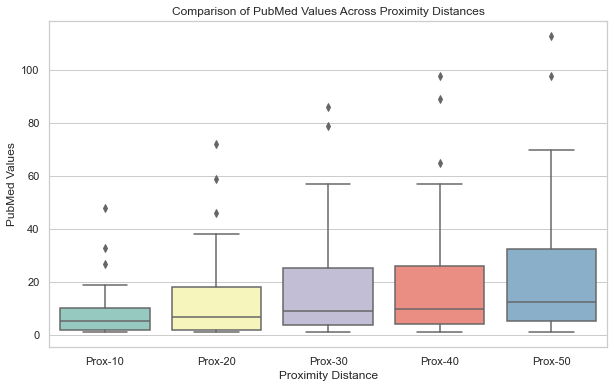

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded the dataframes
# sheet1_df, sheet2_df, sheet3_df, sheet4_df, sheet5_df

# Extracting PubMed column from each dataframe
pubmed_10 = sheet1_df['PubMed']
pubmed_20 = sheet2_df['PubMed']
pubmed_30 = sheet3_df['PubMed']
pubmed_40 = sheet4_df['PubMed']
pubmed_50 = sheet5_df['PubMed']

# Combining all PubMed values into one dataset
all_pubmed = pd.concat([pubmed_10, pubmed_20, pubmed_30, pubmed_40, pubmed_50], axis=1)
all_pubmed.columns = ['Prox-10', 'Prox-20', 'Prox-30', 'Prox-40', 'Prox-50']

# Reshaping the data for boxplot
all_pubmed_melted = all_pubmed.melt(var_name='Proximity Distance', value_name='PubMed')

# Creating a colorful boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Proximity Distance', y='PubMed', data=all_pubmed_melted, palette='Set3')
plt.title('Comparison of PubMed Supporting Evidence Across Proximity Distances')
plt.xlabel('Proximity Distance')
plt.ylabel('PubMed Values')

# Saving the plot to a file
# plt.savefig('/mnt/data/colorful_boxplot_pubmed_freq_per_prox.png')
# plt.savefig('../outputs/boxplot_pubmed_freq_per_prox.png')
plt.show()


                 count       mean        std  min   25%   50%    75%    max  \
Pathway            0.0        NaN        NaN  NaN   NaN   NaN    NaN    NaN   
Proximity Value    0.0        NaN        NaN  NaN   NaN   NaN    NaN    NaN   
PubMed            36.0   8.638889  10.060255  1.0  2.00   5.5  10.25   48.0   
Drugs             36.0   6.972222   6.416435  1.0  2.00   5.5   9.25   25.0   
Proteins          36.0   1.916667   1.338976  1.0  1.00   1.0   3.00    7.0   
Pathway            0.0        NaN        NaN  NaN   NaN   NaN    NaN    NaN   
Proximity Value    0.0        NaN        NaN  NaN   NaN   NaN    NaN    NaN   
PubMed            41.0  13.902439  16.267767  1.0  2.00   7.0  18.00   72.0   
Drugs             41.0  11.024390  10.852391  1.0  2.00   7.0  16.00   43.0   
Proteins          41.0   2.121951   1.417659  1.0  1.00   2.0   3.00    8.0   
Pathway            0.0        NaN        NaN  NaN   NaN   NaN    NaN    NaN   
Proximity Value    0.0        NaN        NaN  NaN   

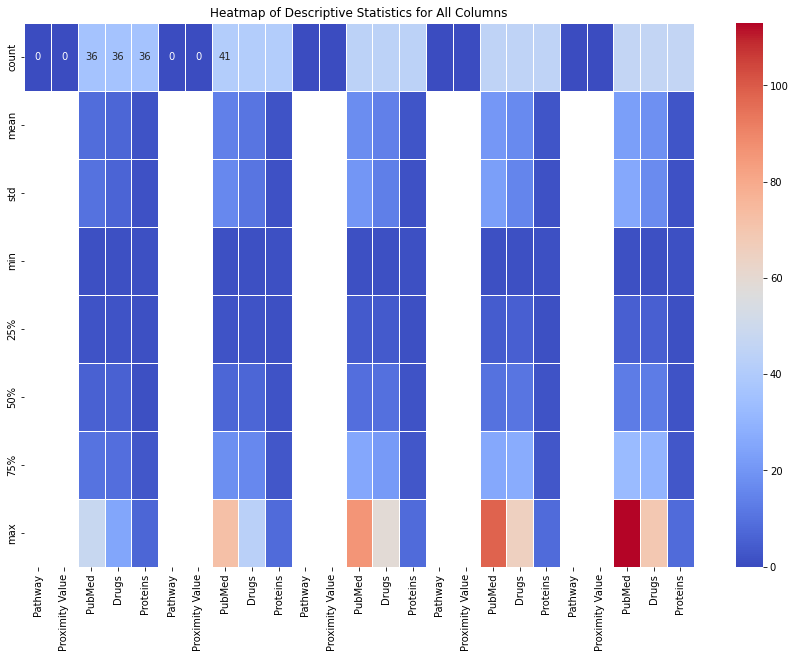

/Users/drhamed/opt/anaconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/drhamed/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/drhamed/opt/anaconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/drhamed/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/drhamed/opt/anaconda3/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/drhamed/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


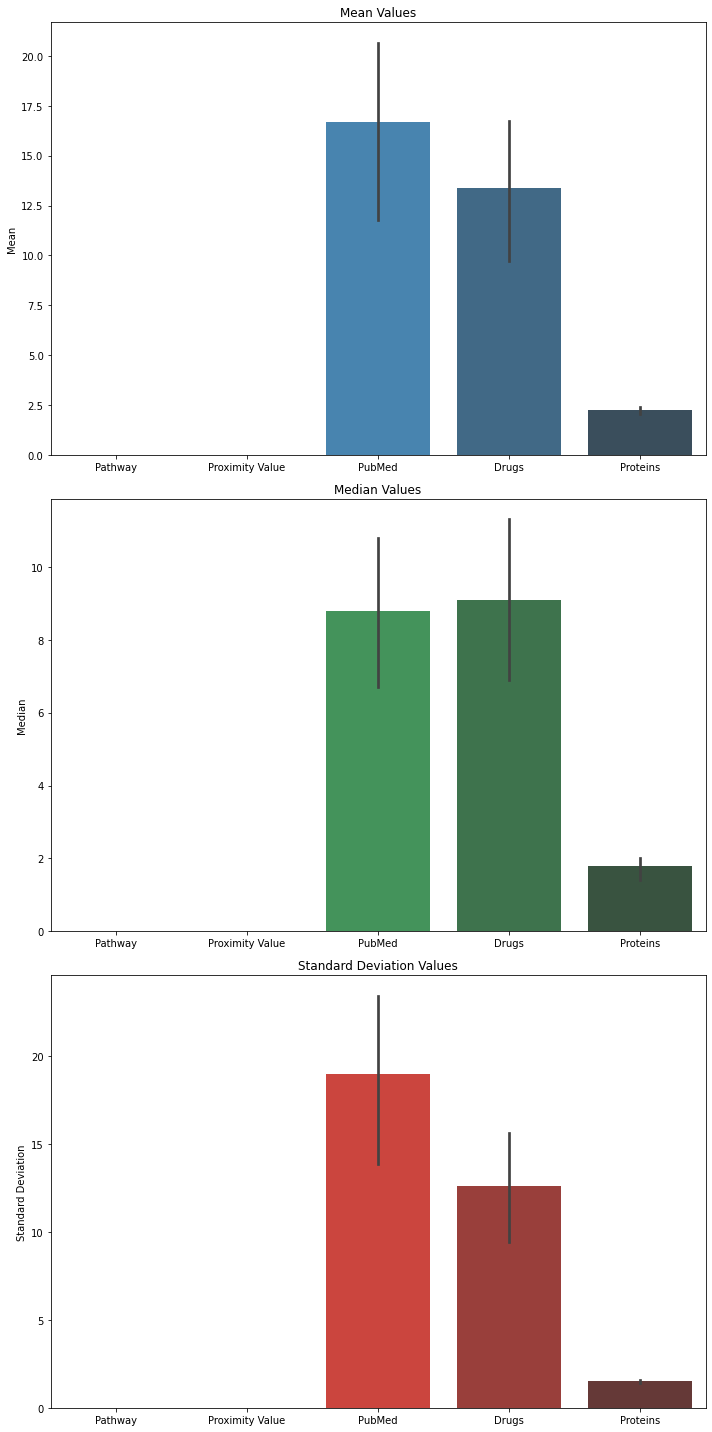

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to ensure all relevant columns are numeric and get descriptive statistics
def get_descriptive_stats(df, sheet_name):
    numeric_df = df.apply(pd.to_numeric, errors='coerce')
    descriptive_stats = numeric_df.describe().transpose()
    descriptive_stats['sheet_name'] = sheet_name
    return descriptive_stats

# Read the Excel file
# file_path = '/mnt/data/disco-by-prox-sheets.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None)

# Get descriptive statistics for each sheet
all_descriptive_stats = []
for sheet_name, df in sheets.items():
    stats = get_descriptive_stats(df, sheet_name)
    all_descriptive_stats.append(stats)

# Combine all descriptive statistics into a single DataFrame
all_descriptive_stats_df = pd.concat(all_descriptive_stats)

# Print combined descriptive statistics
print(all_descriptive_stats_df)

# Visualize the descriptive statistics

# Set up the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(all_descriptive_stats_df.drop(columns='sheet_name').T, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Descriptive Statistics for All Columns')
plt.show()

# Visualize mean, median, and standard deviation for each sheet
mean_values = all_descriptive_stats_df['mean']
median_values = all_descriptive_stats_df['50%']
std_values = all_descriptive_stats_df['std']

fig, ax = plt.subplots(3, 1, figsize=(10, 20))

# Plot mean values
sns.barplot(x=mean_values.index, y=mean_values.values, ax=ax[0], palette='Blues_d')
ax[0].set_title('Mean Values')
ax[0].set_ylabel('Mean')

# Plot median values
sns.barplot(x=median_values.index, y=median_values.values, ax=ax[1], palette='Greens_d')
ax[1].set_title('Median Values')
ax[1].set_ylabel('Median')

# Plot standard deviation values
sns.barplot(x=std_values.index, y=std_values.values, ax=ax[2], palette='Reds_d')
ax[2].set_title('Standard Deviation Values')
ax[2].set_ylabel('Standard Deviation')

plt.tight_layout()
plt.show()


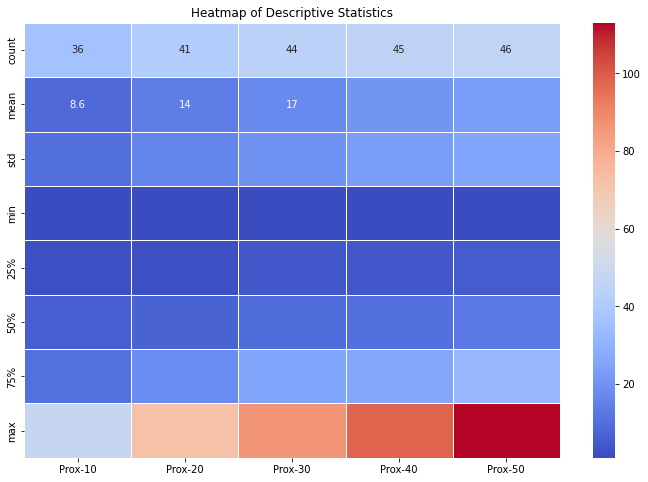

In [30]:
import seaborn as sns

# Set up the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(all_descriptive_stats, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Descriptive Statistics')
plt.show()
